In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score
import sklearn.metrics
import xgboost as xgb
import seaborn as sns
import itertools
import optuna
import lightgbm as lgb

In [4]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [5]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

In [6]:
y = np.log1p(train['Calories'])

X = add_feats(train, numerical_features)

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,36,189,82,26,101,41.0,22.955684,6804,2952,...,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0
1,female,64,163,60,8,85,39.7,22.582709,10432,3840,...,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5
2,female,51,161,64,7,84,39.8,24.690405,8211,3264,...,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2
3,male,20,192,90,25,105,40.7,24.414062,3840,1800,...,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5
4,female,38,166,61,25,102,40.6,22.136740,6308,2318,...,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2


Use Optuna to select model parameters!

In [43]:
def objective(trial):
    # (data, target) = (X, y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=724)
    
    dtrain = lgb.Dataset(X_train, label=y_train)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1e-1),
        'subsample': 0.75,     # trial.suggest_float('subsample', 0.25, 1),   (least important feature)
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 128, 512),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': 20, # trial.suggest_int('min_child_samples', 5, 100)
    }

    # fit_params = {
    #         'early_stopping_rounds': 25, 
    #         'eval_metric': 'rmse',
    #         'verbose': False,
    #         'eval_set': [[X_val, y_val]]
    #         }

    # Initialize and train the model with the suggested hyperparameters
    # model = lgb.train(params, dtrain, num_boost_round=250, valid_sets=lgb.Dataset(X_val, label=y_val), callbacks=[lgb.early_stopping(stopping_rounds=25, verbose=False)])

    model = lgb.LGBMRegressor(**params, n_estimators=200)

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=724)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    # Calculate mean RMSE
    error = np.mean(np.sqrt(-cv_scores))
    return error




if __name__ == "__main__":
    study = optuna.create_study(direction="minimize", study_name='200_boost_rounds_withCV_2', storage="sqlite:///lgbm.db")
    study.optimize(objective, n_trials=200, timeout=7200)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-06-01 09:46:46,213] A new study created in RDB with name: 200_boost_rounds_withCV_2
[I 2025-06-01 09:47:04,646] Trial 0 finished with value: 0.06125424829986516 and parameters: {'learning_rate': 0.07646735747837594, 'lambda_l1': 0.0001446504053796546, 'lambda_l2': 0.17257482507010832, 'num_leaves': 318, 'feature_fraction': 0.5649226124545944, 'bagging_fraction': 0.5164382309453437, 'bagging_freq': 2}. Best is trial 0 with value: 0.06125424829986516.
[I 2025-06-01 09:47:33,425] Trial 1 finished with value: 0.06055731954979582 and parameters: {'learning_rate': 0.050625479563673755, 'lambda_l1': 0.8409557777667431, 'lambda_l2': 0.09028662339826751, 'num_leaves': 484, 'feature_fraction': 0.6186534727493971, 'bagging_fraction': 0.6770322106596841, 'bagging_freq': 6}. Best is trial 1 with value: 0.06055731954979582.
[I 2025-06-01 09:47:51,513] Trial 2 finished with value: 0.06195054567463352 and parameters: {'learning_rate': 0.09561502803692623, 'lambda_l1': 7.802077880745163e-07, 'l

Number of finished trials:  200
Best trial:
  Value: 0.060254756125975376
  Params: 
    learning_rate: 0.03848365066653684
    lambda_l1: 4.953315501231011e-07
    lambda_l2: 3.4136491325383996e-07
    num_leaves: 294
    feature_fraction: 0.6852401370357365
    bagging_fraction: 0.8625853088809784
    bagging_freq: 4


In [38]:
optuna.delete_study(study_name='250_boost_rounds_withCV', storage="sqlite:///lgbm.db")

In [ ]:
# Best trial: (100 boost rounds)
#   Value: 0.06045904947623134
#   Params: 
#     learning_rate: 0.06985208941697417
#     subsample: 0.3283171200162237
#     lambda_l1: 2.762328725593071e-08
#     lambda_l2: 0.05995217777795077
#     num_leaves: 337
#     feature_fraction: 0.7520485829690883
#     bagging_fraction: 0.9858512552484641
#     bagging_freq: 1
#     min_child_samples: 20


# Best trial: (175 boost rounds)
#   Value: 0.06002532809352
#   Params: 
#     learning_rate: 0.04673711453884763
#     subsample: 0.4588016000889745
#     lambda_l1: 2.300516999603136e-06
#     lambda_l2: 0.0004112378033441722
#     num_leaves: 282
#     feature_fraction: 0.8269119112204634
#     bagging_fraction: 0.8993528878197107
#     bagging_freq: 5
#     min_child_samples: 14


# Best trial: (200 boost rounds)
#   Value: 0.060254756125975376
#   Params: 
#     learning_rate: 0.03848365066653684
#     subsample: 0.75
#     lambda_l1: 4.953315501231011e-07
#     lambda_l2: 3.4136491325383996e-07
#     num_leaves: 294
#     feature_fraction: 0.6852401370357365
#     bagging_fraction: 0.8625853088809784
#     bagging_freq: 4
#     min_child_samples: 20


# Best trial: (200 boost rounds)
#   Value: 0.060269815319907216
#   Params: 
#     learning_rate: 0.04459481667197035
#     subsample: 0.2822312071389545
#     lambda_l1: 8.208387669605536e-07
#     lambda_l2: 0.0004479481141987028
#     num_leaves: 322
#     feature_fraction: 0.7067834487293196
#     bagging_fraction: 0.9686463810691792
#     bagging_freq: 7
#     min_child_samples: 23


# Best trial: (250 boost rounds)
#   Value: 0.060241397692019895
#   Params: 
#     learning_rate: 0.034957481193221375
#     subsample: 0.6030381626348587
#     lambda_l1: 2.16611846369014e-05
#     lambda_l2: 2.107594440608458e-07
#     num_leaves: 154
#     feature_fraction: 0.6822569463675131
#     bagging_fraction: 0.9835271701916218
#     bagging_freq: 3
#     min_child_samples: 5

In [5]:
number_leaves = [200, 300, 400]
learning_rate = [0.1, 0.05]
number_boosts = [100, 200, 300]
subsamp = [0.9]

model_err = {}

for nl, lr, nbr, ss in itertools.product(number_leaves, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = lgb.Dataset(X_train, label=y_train)
                
        # Define parameters
        params = {
            'num_leaves': nl,
            'learning_rate': lr,
            'objective': 'regression',  # same as rmse
            'metric': 'rmse',           # 
            'force_col_wise': True,     # Optional: can help with categorical support
            'subsample': ss,
            #'class_weight': 'balanced',
            'verbose': -1
        }

        # Initialize and train the model
        model = lgb.train(params, dtrain, num_boost_round=nbr, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=25, verbose=False)])


        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=200, learn_rate=0.1, num_boost=100, subsample=0.9: 0.060540451681839816
Mean Accuracy for num_leaves=200, learn_rate=0.1, num_boost=200, subsample=0.9: 0.06066132105034068
Mean Accuracy for num_leaves=200, learn_rate=0.1, num_boost=300, subsample=0.9: 0.0606620694948908
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=100, subsample=0.9: 0.061107452542269604
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=200, subsample=0.9: 0.060312453672059396
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=300, subsample=0.9: 0.06026045503411256
Mean Accuracy for num_leaves=300, learn_rate=0.1, num_boost=100, subsample=0.9: 0.060535992616533786
Mean Accuracy for num_leaves=300, learn_rate=0.1, num_boost=200, subsample=0.9: 0.06054042336355249
Mean Accuracy for num_leaves=300, learn_rate=0.1, num_boost=300, subsample=0.9: 0.060467839808901726
Mean Accuracy for num_leaves=300, learn_rate=0.05, num_boost=100, subsample=0.9: 0.0608905472

In [6]:
number_leaves = [250, 300, 350]
learning_rate = [0.1, 0.05]
number_boosts = [150, 200, 250]
subsamp = [0.75, 0.9]

model_err = {}

for nl, lr, nbr, ss in itertools.product(number_leaves, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = lgb.Dataset(X_train, label=y_train)
                
        # Define parameters
        params = {
            'num_leaves': nl,
            'learning_rate': lr,
            'objective': 'regression',  # same as rmse
            'metric': 'rmse',           # 
            'force_col_wise': True,     # Optional: can help with categorical support
            'subsample': ss,
            #'class_weight': 'balanced',
            'verbose': -1
        }

        # Initialize and train the model
        model = lgb.train(params, dtrain, num_boost_round=nbr, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=25, verbose=False)])


        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=250, learn_rate=0.1, num_boost=150, subsample=0.75: 0.06051733995536668
Mean Accuracy for num_leaves=250, learn_rate=0.1, num_boost=150, subsample=0.9: 0.06055473547247185
Mean Accuracy for num_leaves=250, learn_rate=0.1, num_boost=200, subsample=0.75: 0.06059788541175679
Mean Accuracy for num_leaves=250, learn_rate=0.1, num_boost=200, subsample=0.9: 0.06044450613396233
Mean Accuracy for num_leaves=250, learn_rate=0.1, num_boost=250, subsample=0.75: 0.06055311385608146
Mean Accuracy for num_leaves=250, learn_rate=0.1, num_boost=250, subsample=0.9: 0.060610778858321036
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=150, subsample=0.75: 0.06034198810786453
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=150, subsample=0.9: 0.060310681193687835
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=200, subsample=0.75: 0.06026090112106094
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=200, subsample=0.9: 0.0603233

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[198]	valid_0's rmse: 0.06016
0.054296682879093776


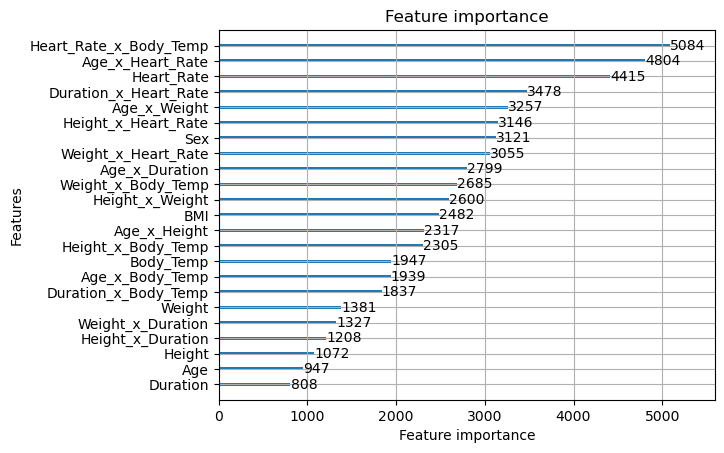

In [ ]:
# Kaggle score 0.05802 pub, 0.05935 priv, lgb_prediction_23.csv

# Best trial: (200 boost rounds)
#   Value: 0.060254756125975376
#   Params: 
#     learning_rate: 0.03848365066653684
#     subsample: 0.75
#     lambda_l1: 4.953315501231011e-07
#     lambda_l2: 3.4136491325383996e-07
#     num_leaves: 294
#     feature_fraction: 0.6852401370357365
#     bagging_fraction: 0.8625853088809784
#     bagging_freq: 4
#     min_child_samples: 20

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'learning_rate': 0.03848365066653684,
    'subsample': 0.75,
    'lambda_l1': 4.953315501231011e-07,
    'lambda_l2': 3.4136491325383996e-07,
    'num_leaves': 294,
    'feature_fraction': 0.6852401370357365,
    'bagging_fraction': 0.8625853088809784,
    'bagging_freq': 4,
    'min_child_samples': 20,
    'objective': 'regression',
    'metric': 'rmse',
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=200, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)])

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred[test_pred < 0] = 1

print(rmse(test_pred, y_train))

lgb.plot_importance(model)
plt.show()

Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[250]	valid_0's rmse: 0.0608647
0.053259641868687174


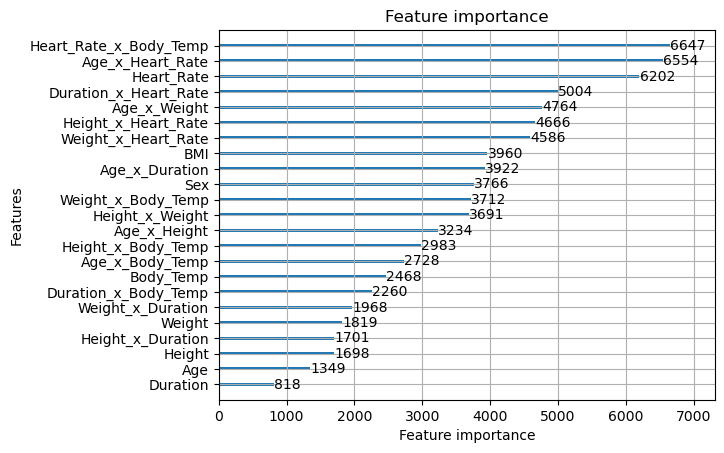

In [ ]:
# Kaggle score 0.05792 pub, 0.05927 priv, lgb_prediction_22.csv

# Best trial:
#   Value: 0.059868610569266005
#   Params: 
#     learning_rate: 0.03293641975034637
#     subsample: 0.34637034698062785
#     lambda_l1: 2.0876570695580415e-07
#     lambda_l2: 1.9599902204772803
#     num_leaves: 323
#     feature_fraction: 0.7506830211750437
#     bagging_fraction: 0.9843257331204426
#     bagging_freq: 1
#     min_child_samples: 16

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'learning_rate': 0.03293641975034637,
    'subsample': 0.34637034698062785,
    'lambda_l1': 2.0876570695580415e-07,
    'lambda_l2': 1.9599902204772803,
    'num_leaves': 323,
    'feature_fraction': 0.7506830211750437,
    'bagging_fraction': 0.9843257331204426,
    'bagging_freq': 1,
    'min_child_samples': 16,
    'objective': 'regression',
    'metric': 'rmse',
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=250, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=25, verbose=True)])

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred[test_pred < 0] = 1

print(rmse(test_pred, y_train))

lgb.plot_importance(model)
plt.show()

Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[173]	valid_0's rmse: 0.0601072
0.05340924110038583


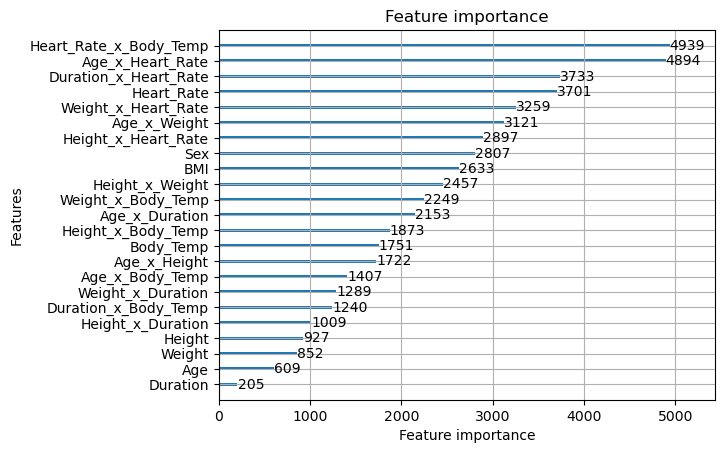

In [ ]:
# Kaggle score 0.05826, lgb_prediction_20.csv, num_leaves 300, learning rate 0.05, subsample 0.75, boost rounds 200, stopping rounds 25

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'num_leaves': 300,
    'learning_rate': 0.05,
    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
    'metric': 'rmse',           # We'll manually compute RMSLE
    'force_col_wise': True,     # Optional: can help with categorical support
    #'class_weight': 'balanced',
    'subsample': 0.75
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=200, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=25, verbose=True)])

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred[test_pred < 0] = 1

print(rmse(test_pred, y_train))

lgb.plot_importance(model)
plt.show()

In [13]:
test_mod = add_feats(test, numerical_features)

test_mod.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,45,177,81,7,87,39.8,25.854639,7965,3645,...,14337,1239,15399,7044.6,567,7047,3223.8,609,278.6,3462.6
1,male,26,200,97,20,101,40.5,24.250000,5200,2522,...,19400,4000,20200,8100.0,1940,9797,3928.5,2020,810.0,4090.5
2,female,29,188,85,16,102,40.4,24.049344,5452,2465,...,15980,3008,19176,7595.2,1360,8670,3434.0,1632,646.4,4120.8
3,female,39,172,73,20,107,40.6,24.675500,6708,2847,...,12556,3440,18404,6983.2,1460,7811,2963.8,2140,812.0,4344.2
4,female,30,173,67,16,94,40.5,22.386314,5190,2010,...,11591,2768,16262,7006.5,1072,6298,2713.5,1504,648.0,3807.0


In [45]:
# make the submission file!

pred = model.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test_mod))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("lgb_prediction_23.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.296364
1  750001  108.703934
2  750002   87.742418
3  750003  126.895697
4  750004   75.698200

count    250000.000000
mean         88.142895
std          62.205561
min           0.980323
25%          34.043081
50%          76.423349
75%         135.416058
max         293.853491
Name: Calories, dtype: float64


Remove least important features and try again!

In [6]:
feat_del = ['Duration', 'Age', 'Weight', 'Height']

Xtrim = X.drop(columns=feat_del)
test_mod_trim = test_mod.drop(columns=feat_del)

Xtrim.head()

,Sex,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,Age_x_Duration,Age_x_Heart_Rate,Age_x_Body_Temp,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,101,41.0,22.955684,6804,2952,936,3636,1476.0,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0
1,female,85,39.7,22.582709,10432,3840,512,5440,2540.8,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5
2,female,84,39.8,24.690405,8211,3264,357,4284,2029.8,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2
3,male,105,40.7,24.414062,3840,1800,500,2100,814.0,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5
4,female,102,40.6,22.136740,6308,2318,950,3876,1542.8,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2


In [13]:
number_leaves = [150, 200, 250, 300, 350]
learning_rate = [0.05]
number_boosts = [200, 300, 400]
subsamp = [0.9]

model_err = {}

for nl, lr, nbr, ss in itertools.product(number_leaves, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=724)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(Xtrim):

        X_train, X_test = Xtrim.loc[train_index], Xtrim.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = lgb.Dataset(X_train, label=y_train)
                
        # Define parameters
        params = {
            'num_leaves': nl,
            'learning_rate': lr,
            'objective': 'regression',  # same as rmse
            'metric': 'rmse',           # 
            'force_col_wise': True,     # Optional: can help with categorical support
            'subsample': ss,
            #'class_weight': 'balanced',
            'verbose': -1
        }

        # Initialize and train the model
        model = lgb.train(params, dtrain, num_boost_round=nbr, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=25, verbose=False)])


        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=150, learn_rate=0.05, num_boost=200, subsample=0.9: 0.06031407298821635
Mean Accuracy for num_leaves=150, learn_rate=0.05, num_boost=300, subsample=0.9: 0.06026916018962782
Mean Accuracy for num_leaves=150, learn_rate=0.05, num_boost=400, subsample=0.9: 0.06026916018962782
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=200, subsample=0.9: 0.060226612884472376
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=300, subsample=0.9: 0.06021761521862277
Mean Accuracy for num_leaves=200, learn_rate=0.05, num_boost=400, subsample=0.9: 0.06021761521862277
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=200, subsample=0.9: 0.06016602545936591
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=300, subsample=0.9: 0.060164292879339776
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=400, subsample=0.9: 0.060164292879339776
Mean Accuracy for num_leaves=300, learn_rate=0.05, num_boost=200, subsample=0.9: 0.06018

In [15]:
number_leaves = [225, 250, 275]
learning_rate = [0.05]
number_boosts = [250, 300, 350]
subsamp = [0.75, 0.9]

model_err = {}

for nl, lr, nbr, ss in itertools.product(number_leaves, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=724)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(Xtrim):

        X_train, X_test = Xtrim.loc[train_index], Xtrim.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = lgb.Dataset(X_train, label=y_train)
                
        # Define parameters
        params = {
            'num_leaves': nl,
            'learning_rate': lr,
            'objective': 'regression',  # same as rmse
            'metric': 'rmse',           # 
            'force_col_wise': True,     # Optional: can help with categorical support
            'subsample': ss,
            #'class_weight': 'balanced',
            'verbose': -1
        }

        # Initialize and train the model
        model = lgb.train(params, dtrain, num_boost_round=nbr, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=25, verbose=False)])


        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for num_leaves={nl}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"num_leaves_{nl}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for num_leaves=225, learn_rate=0.05, num_boost=250, subsample=0.75: 0.06021221972286067
Mean Accuracy for num_leaves=225, learn_rate=0.05, num_boost=250, subsample=0.9: 0.06021221972286067
Mean Accuracy for num_leaves=225, learn_rate=0.05, num_boost=300, subsample=0.75: 0.06021221972286067
Mean Accuracy for num_leaves=225, learn_rate=0.05, num_boost=300, subsample=0.9: 0.06021221972286067
Mean Accuracy for num_leaves=225, learn_rate=0.05, num_boost=350, subsample=0.75: 0.06021221972286067
Mean Accuracy for num_leaves=225, learn_rate=0.05, num_boost=350, subsample=0.9: 0.06021221972286067
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=250, subsample=0.75: 0.060164292879339776
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=250, subsample=0.9: 0.060164292879339776
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=300, subsample=0.75: 0.060164292879339776
Mean Accuracy for num_leaves=250, learn_rate=0.05, num_boost=300, subsample=0.9: 0.

Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[169]	valid_0's rmse: 0.0601556
0.05437826404404836


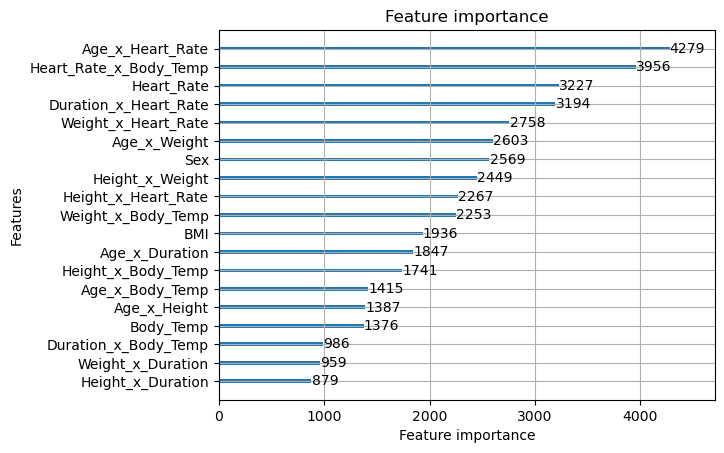

In [ ]:
# Kaggle score 0.05818, lgb_prediction_21.csv, num_leaves 250, learning rate 0.05, subsample 0.75, boost rounds 250, stopping rounds 25

num_indices = 600000

train_index = np.random.choice(Xtrim.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(Xtrim))) - set(train_index))


X_train, X_test = Xtrim.loc[train_index], Xtrim.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

dtrain = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'num_leaves': 250,
    'learning_rate': 0.05,
    'objective': 'regression',  # LightGBM doesn't have squaredlogerror directly
    'metric': 'rmse',           # We'll manually compute RMSLE
    'force_col_wise': True,     # Optional: can help with categorical support
    #'class_weight': 'balanced',
    'subsample': 0.75
}

# Train the model
model = lgb.train(params, dtrain, num_boost_round=250, valid_sets=lgb.Dataset(X_test, label=y_test), callbacks=[lgb.early_stopping(stopping_rounds=25, verbose=True)])

# Make predictions
test_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
test_pred[test_pred < 0] = 1

print(rmse(test_pred, y_train))

lgb.plot_importance(model)
plt.show()

In [18]:
# make the submission file!

pred = model.predict(test_mod_trim)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test_mod_trim))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("lgb_prediction_21.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.452328
1  750001  108.432034
2  750002   86.719099
3  750003  126.482134
4  750004   75.474427

count    250000.000000
mean         88.159722
std          62.240340
min           0.933310
25%          34.046752
50%          76.464383
75%         135.394784
max         294.750264
Name: Calories, dtype: float64
